# Deep Learning: Final Project - Exploratory Data Analysis and ML Pipeline
The following analysis aims to utilize deep learning approaches to build an object detection model that can identify and localize objects in images using bounding boxes. As part of this project, I shall perform an extensive exploratory data analysis, identify and then perform analyzes using multiple deep learning models, present discussions and conclusions. 

### Use Case: Identify and Localize Objects in Images
#### Problem Description:
The Kaggle 26 Class Object Detection Dataset contains images taken from real-worl environments such as streets, indoor scenes, and urban sorroundings. Each image generally contains one or more annotated objects belonging to 26 distinct classes, including pedestrians, bicycles, vehicles, traffic lights, and other everyday objects. 

Each object is labeled with:
- a class name
- a bounding box (xmin, ymin, xmay, ymax)

#### Type of Learning & Task: 
- Type: Supervised Learning
- Task: Object detection - which combines object classification with bounding box prediction of multiple objects

#### Goal: 
The goal is to build a pipeline that can accurately detect and localize objects across the classes present in the dataset. Specifically, this includes being able to interpret the model's performances and provide a meaningful discussion around the results. Hence, the emphasis is also on producing a reproducible deep-learning workflow. 

#### Importance and Motivation: 
Object detection in natural scenes is used in many real-world applications including urban planning, environmental monitoring, disaster assessment, military, security, and autonomous driving. The dataset offers complex scenes with small, densely packed and variably oriented objects which makes it a strong test case for modern detection models.

#### Github Repository
...

#### Data Source
The dataset is publicly available on Kaggle under:
Gobara, Mohamed. "26 Class Object detection dataset: Comprehensive 26-Class Object Detection Dataset for Urban Scenes" Kaggle, 2023. https://www.kaggle.com/datasets/mohamedgobara/26-class-object-detection-dataset/data.

The dataset consists of 38952 images. Several preprocessing steps have been applied to the images including: 
- Auto-orientiation of pixel data
- Resize to 300x300
- 3 versions of each source image were created using salt and pepper noise
  
#### Table of Contents: 

1. Data Summary
2. Exploratory Data Analysis
3. Data Cleaning
4. Data Preprocessing
5. Modeling - Comparison of 2 Models
6. Hyperparameter Tuning
7. Results & Analysis
8. Conclusion
9. Areas for Further Exploration

In [1]:
import json
import pandas as pd
from pathlib import Path
import os
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
#import torch
#from torchvision import models, transforms
from PIL import Image
from sklearn.manifold import TSNE
import random
from IPython.display import display
import shutil
import yaml
import seaborn as sns
#from ultralytics import YOLO


### Load Data: Train, Test, Validation

In [ ]:
BASE_DIR = Path("/kaggle/input/26-class-object-detection-dataset/Senior-Design-VIAD-4")

def load_coco_split(split: str):

    json_path = BASE_DIR / split / "_annotations.coco.json"
    with open(json_path, "r") as f:
        data = json.load(f)

    images = pd.DataFrame(data["images"])
    annotations = pd.DataFrame(data["annotations"])
    categories = pd.DataFrame(data["categories"])

    # add full file path to images
    images["full_path"] = images["file_name"].apply(lambda x: str(BASE_DIR / split / x))
    return images, annotations, categories

train_imgs, train_ann, train_cat = load_coco_split("train")
valid_imgs, valid_ann, valid_cat = load_coco_split("valid")
test_imgs,  test_ann,  test_cat  = load_coco_split("test")


## 1. Data Summary

In [ ]:
def check_data_consistency(split: str, imgs: pd.DataFrame, ann: pd.DataFrame):
    print(f"\nChecking split: {split}")

    # 1. Total images & Total Annotations
    total_imgs = len(imgs)
    total_ann = len(ann)
    print("1. Total Images & Total Annotations:")
    print(f"[INFO] Total Images: {total_imgs}")
    print(f"[INFO] Total Annotations: {total_ann}")

    # 2. Image_id in annotations must exist in images
    image_ids_in_imgs = set(imgs["id"])
    image_ids_in_ann = set(ann["id"])
    missing_image_ids = image_ids_in_ann - image_ids_in_imgs
    print("2. Check existence of image_ids:")
    if missing_image_ids:
        print(f"[ERROR] {len(missing_image_ids)} annotated image_ids not found in images_id")

    else: 
        print(f"[SUCCESS] All annotated images id's exist as images in the folder")

    # 3. Images with no annotations 
    ''' Images without annotations aren't necessarily bad, but it helps to know about them.'''
    ann_counts = ann["id"].value_counts()
    imgs["ann_count"] = imgs["id"].map(ann_counts).fillna(0).astype(int)
    no_ann = imgs[imgs["ann_count"] == 0]
    print("3. Number of Annotations:")
    print(f"[INFO] Images with at least one annotation: {(imgs['ann_count'] > 0).sum()}")
    print(f"[INFO] Images with NO annotations: {len(no_ann)}")

    # 4. Duplicate ids or file_names
    dup_ids = imgs["id"][imgs["id"].duplicated()]
    dup_files = imgs["file_name"][imgs["file_name"].duplicated()]
    print("4. Duplicate IDs or File_Names:")
    if len(dup_ids) > 0:
        print(f"[ERROR] Duplicate image IDs: {len(dup_ids.unique())}")
    else:
        print("[SUCCESS] No Duplicate image IDs")
    if len(dup_files) > 0:
        print(f"[ERROR] Duplicate image files: {len(dup_files.unique())}")
    else:
        print("[SUCCESS] No Duplicate image files")

train_report = check_data_consistency("train", train_imgs, train_ann)
valid_report = check_data_consistency("valid", valid_imgs, valid_ann)
test_report  = check_data_consistency("test",  test_imgs,  test_ann)


Checking split: train
1. Total Images & Total Annotations:
[INFO] Total Images: 32511
[INFO] Total Annotations: 54480
2. Check existence of image_ids:
[ERROR] 21969 annotated image_ids not found in images_id
3. Number of Annotations:
[INFO] Images with at least one annotation: 32511
[INFO] Images with NO annotations: 0
4. Duplicate IDs or File_Names:
[SUCCESS] No Duplicate image IDs
[SUCCESS] No Duplicate image files

Checking split: valid
1. Total Images & Total Annotations:
[INFO] Total Images: 4246
[INFO] Total Annotations: 7255
2. Check existence of image_ids:
[ERROR] 3009 annotated image_ids not found in images_id
3. Number of Annotations:
[INFO] Images with at least one annotation: 4246
[INFO] Images with NO annotations: 0
4. Duplicate IDs or File_Names:
[SUCCESS] No Duplicate image IDs
[SUCCESS] No Duplicate image files

Checking split: test
1. Total Images & Total Annotations:
[INFO] Total Images: 2165
[INFO] Total Annotations: 3730
2. Check existence of image_ids:
[ERROR] 156

### 1.1 Analysis of the Data Summmary
##### Why do images appear with no annotations?
1. Some images genuinely contain no objects of interest:
Object detection datasets ofter contain images where no labeled object appears, objects are too small, or the annotator intentionally marked the image as "background only". This helps the model learn negative examples and actually improves confidence calibration and robustness to cluttered scenes. 1.74% of train images are unlabeled wwhich is normal for a dataset of this size. 
2. It is common for annotators to miss labeling images:
It is not uncommon for labeling runs to be incomplete or for human annotators to accasionally skip objects in an images.
##### Are unlabeled images problematic?
No, not at all. In fact many models expect unlabeled images and interpret them as valid negative samples. The rates within each folder are similar. 
##### Should unlabeled images be removed?
No, because:
- They help reduce false positives
- Privide background variability
- They can improve generalization

One should only remove such files if they are perhaps unrelated to the domain or unlabeled images where to outnumber labeled images, which is not the case. Therefore, it appears that: 
- The dataset is clean
- All ID' match
- There are no duplicated
- The percentage of unlabeled images is small and healthy

## 2. Exploratory Data Analysis
### 2.1 Number of Images per Class across Train, Valid, and Test

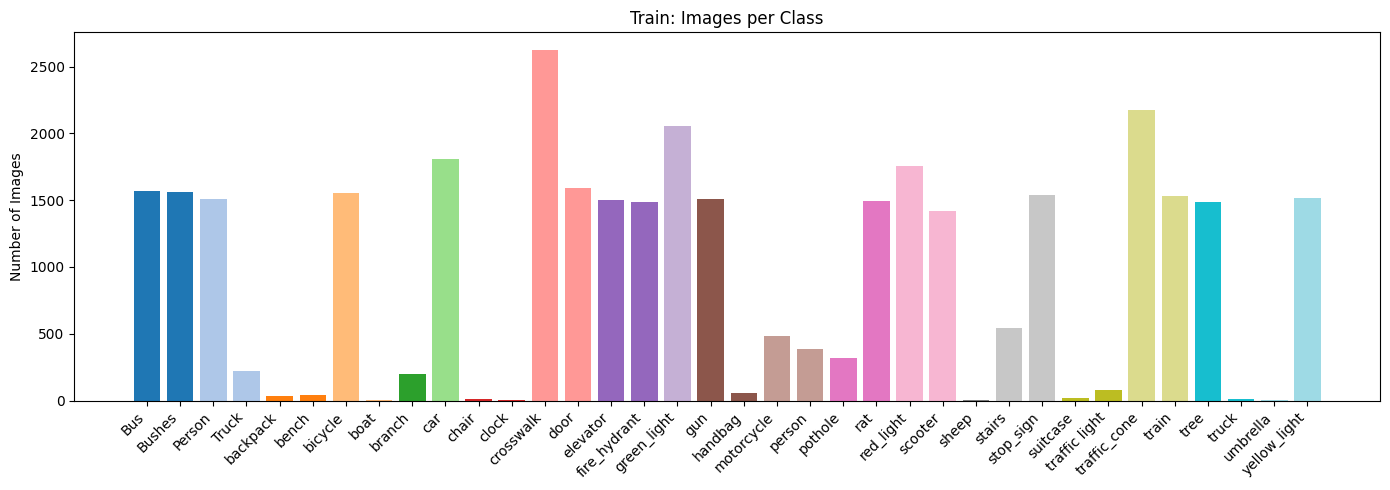

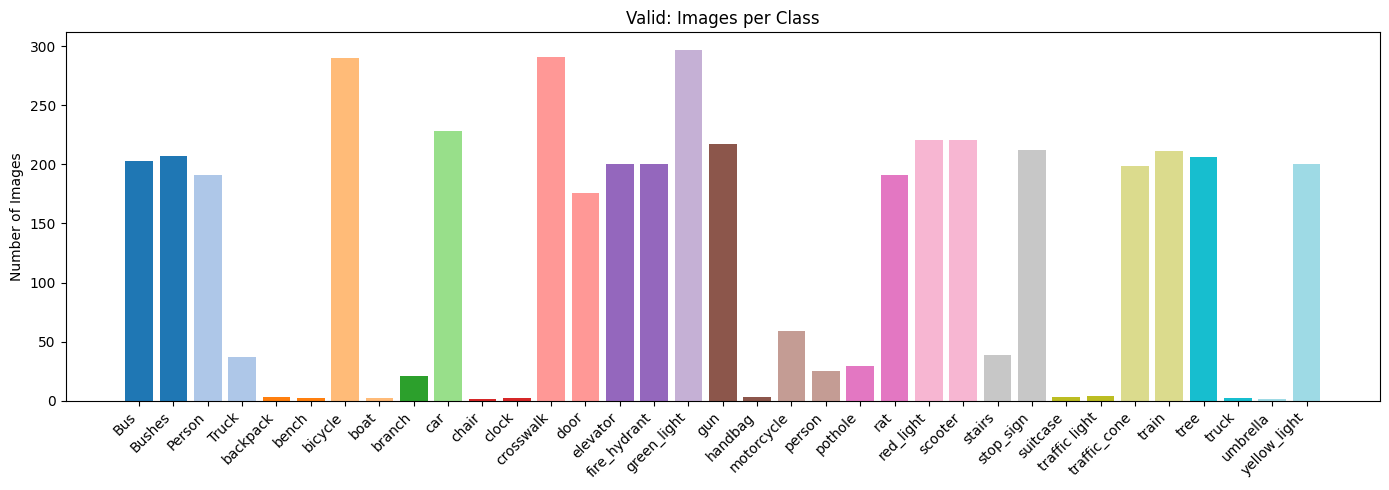

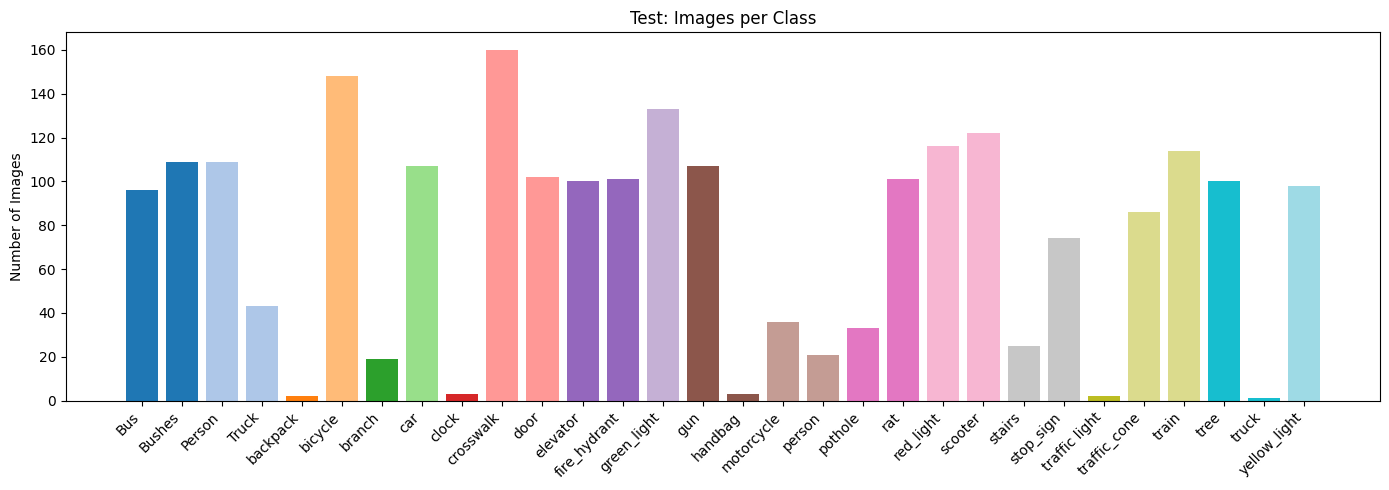

In [ ]:
def count_images_per_class(images_df, annotations_df, categories_df):
    # Map category to name
    id_to_name = categories_df.set_index("id")["name"].to_dict()

    # For each class, find the unique image_ids
    class_to_images = (
        annotations_df.groupby("category_id")["image_id"]
        .apply(lambda g: g.unique())
        .to_dict()
    )

    # Count number of images in each class
    class_counts = {
        id_to_name[category_id]: len(imgs_ids)
        for category_id, imgs_ids in class_to_images.items()
    }
    # Convet to pandas Series sorte by class name
    return pd.Series(class_counts).sort_index()

# Define coloring scheme
def class_colors(categories_df):
    class_names = categories_df["name"].sort_values().tolist()
    cmap = plt.get_cmap("tab20", len(class_names))
    colors = {cls: cmap(i) for i, cls in enumerate(class_names)}
    return colors

def plot_images(class_counts, title, colors):
    plt.figure(figsize=(14, 5))
    # Match Class Names to Colors
    bar_colors = [colors[cls] for cls in class_counts.index]

    plt.bar(class_counts.index, class_counts.values, color=bar_colors)
    plt.title(title)
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

colors = class_colors(train_cat)

# Count images per class
train_counts = count_images_per_class(train_imgs, train_ann, train_cat)
valid_counts = count_images_per_class(valid_imgs, valid_ann, valid_cat)
test_counts = count_images_per_class(test_imgs,  test_ann,  test_cat)

# Plot
plot_images(train_counts, "Train: Images per Class", colors)
plot_images(valid_counts, "Valid: Images per Class", colors)
plot_images(test_counts, "Test: Images per Class",  colors)

### 2.1.1 Analysis of Class Balance
- Severe Class Imbalance: several class (eg. bicycle, car, crosswalk, green_llight, traffic_cone, etc) have very high counts, while others (truck, backpack, bench, boat, chari, sheep, etc) have extremely few samples - some nearly negligible.
- Train/Valid/Test splits are consistent: the relative proportions of each class remain rougly the same across the splits
- Rare classes will be problematic: classes with very low counts are likely to hurt model performance, unless rebalances or handled with augmentation / sampling strategies
- Common classes will dominate learning: the model will naturally bias toward high-frequency classes unless weighted losses or sampling corrections are utilized

### 2.2 Missing Classes in Valid & Test vs. Train

In [ ]:
comparison_df = pd.DataFrame({
    "train": train_counts, 
    "valid": valid_counts,
    "test": test_counts
})

comparison_df = comparison_df.fillna(0).astype(int)
missing_in_valid = comparison_df[comparison_df["valid"] == 0]
missing_in_test = comparison_df[comparison_df["test"] == 0]

print("Classes missing in VALID vs. TRAIN: ", missing_in_valid.index.tolist())
print("Classes missing in TEST vs. TRAIN: ", missing_in_test.index.tolist())

Classes missing in VALID vs. TRAIN:  ['sheep']
Classes missing in TEST vs. TRAIN:  ['bench', 'boat', 'chair', 'sheep', 'suitcase', 'umbrella']


### 2.3 Normalized Class Distribution Across Train, Valid, and Test
The number of images in train is significantly higher, therefore normalization is necessary to plot a comparison of number of images per class. 

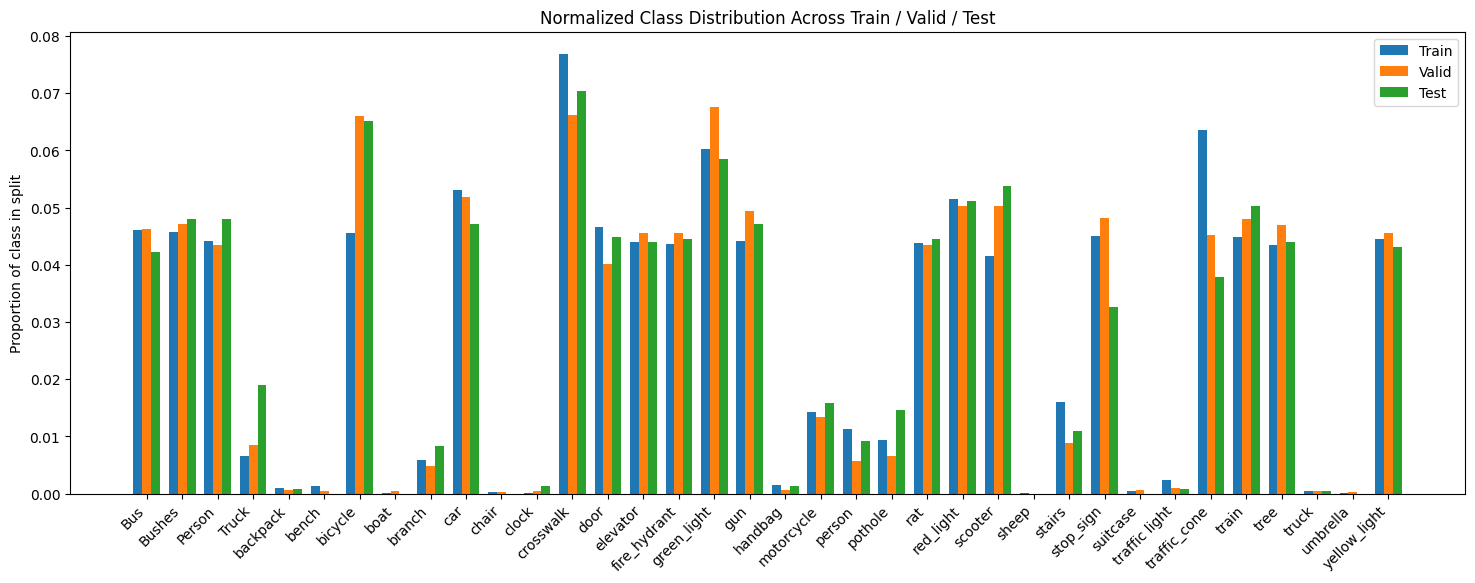

In [ ]:
def normalized_distribution(comparison_df):
    # Normalize each class
    df_norm = comparison_df.div(comparison_df.sum(axis=0), axis = 1)
    classes = df_norm.index
    x = np.arange(len(classes))
    width = 0.25
    
    plt.figure(figsize=(18,6))
    plt.bar(x-width, df_norm["train"], width, label = "Train", color="tab:blue")
    plt.bar(x, df_norm["valid"], width, label = "Valid", color="tab:orange")
    plt.bar(x+width, df_norm["test"], width, label = "Test", color="tab:green")
    plt.xticks(x, classes, rotation=45, ha="right")
    plt.ylabel("Proportion of class in split")
    plt.title("Normalized Class Distribution Across Train / Valid / Test")
    plt.legent()
    plt.show()

normalized_distribution(comparison_df)

This analysis underpins the previous conclusion on consistent split. The relative proportions of each class remain rougly the same across the splits.

### 2.4 Number of Annotations per Class Across Train, Valid, and Test

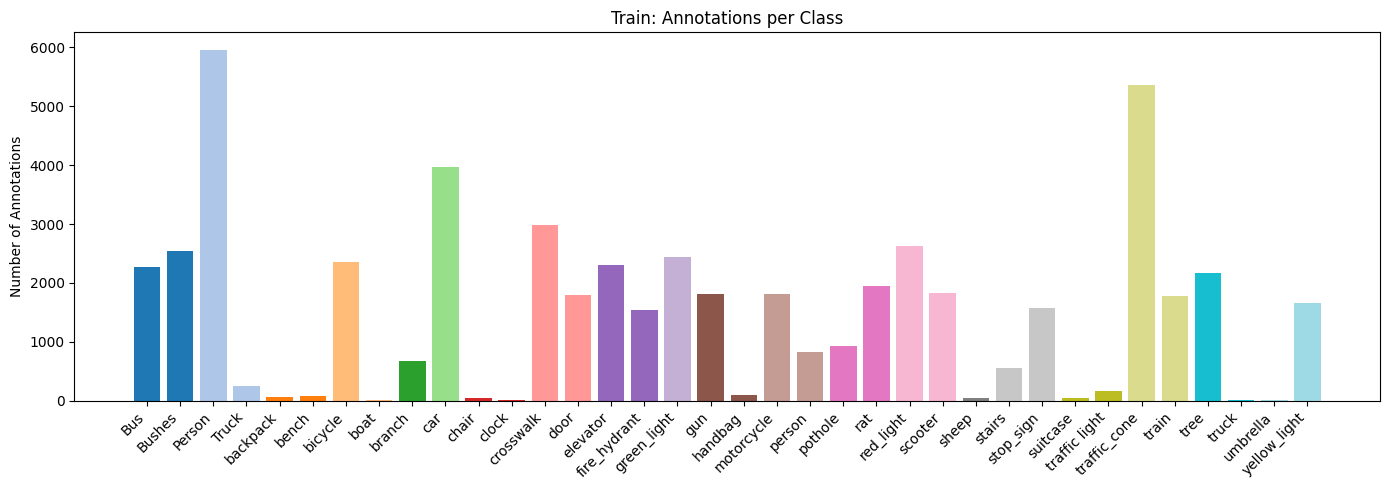

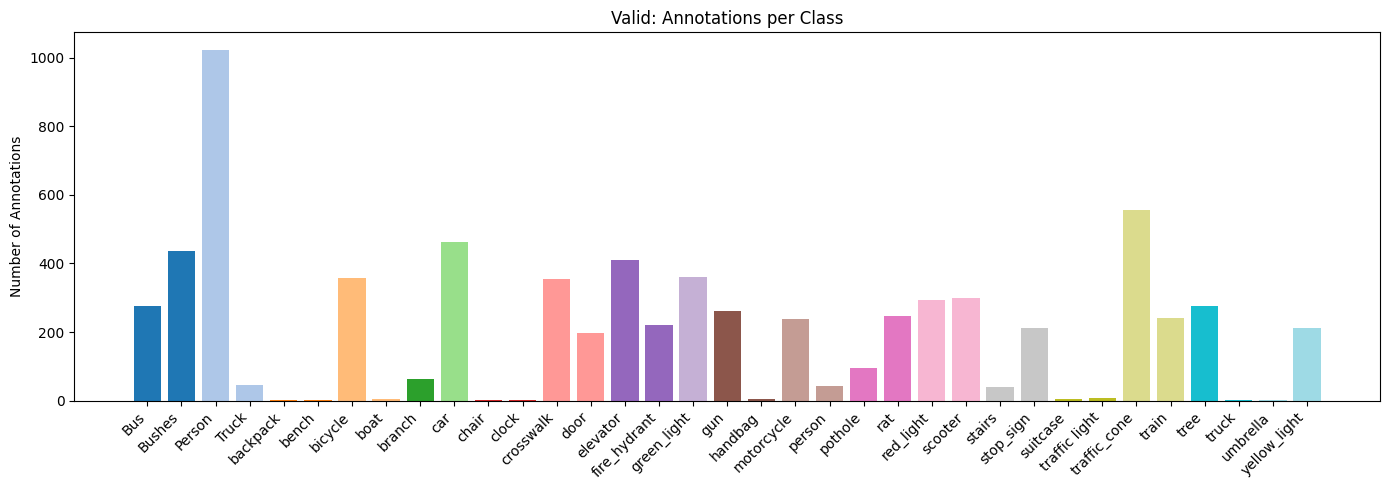

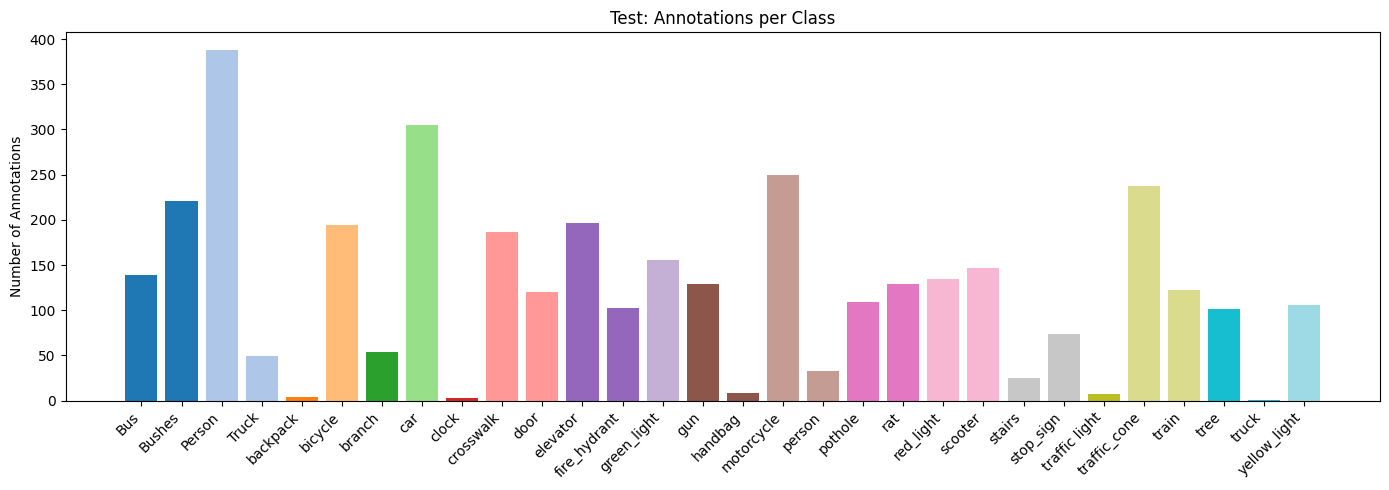

In [ ]:
def count_annotations_per_class(ann_df, categories_df):
    id_to_name = categories_df.set_index("id")["name"].to_dict()
    counts = ann_df["category_id"].value_counts().sort_index()
    counts.index = [id_to_name[category_id] for category_id in counts.index]
    return counts.sort_index()

def plot_annotations(class_counts, title, colors):
    all_classes = sorted(colors.keys())
    counts = class_counts.reindec(all_classes).fillna(0)

    plt.figure(figsize=(14,5))
    # Match class names to colors
    bar_colors = [colors[cls] for cls in counts.index]
    plt.bar(counts.index, counts.values, color = bar_colors)
    plt.title(title)
    plt.ylabel("Number of Annotations")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

train_ann_counts = count_annotations_per_class(train_ann, train_cat)
valid_ann_counts = count_annotations_per_class(valid_ann, valid_cat)
test_ann_counts  = count_annotations_per_class(test_ann,  test_cat)

plot_annotations(train_ann_counts, "Train: Annotations per Class", colors)
plot_annotations(valid_ann_counts, "Valid: Annotations per Class", colors)
plot_annotations(test_ann_counts,  "Test: Annotations per Class",  colors)

### 2.4.1 Analysis of Annotation Balance
- Severe Imbalance: Person, Car, traffic_cone are strongly represented with a high number of total annotations. Other classes such as backpack, umbrella, boat are severely underrepresented with few annotations. This will make them difficult to learn for the model.
- Distribution of annotations is stable across splits
- Model will likely bias toward frequent annotation categories without rebalancing. Recall on rare-classes is likely to be low. 

### 2.5 Normalized Annotation Distribution Across Train, Valid, and Test

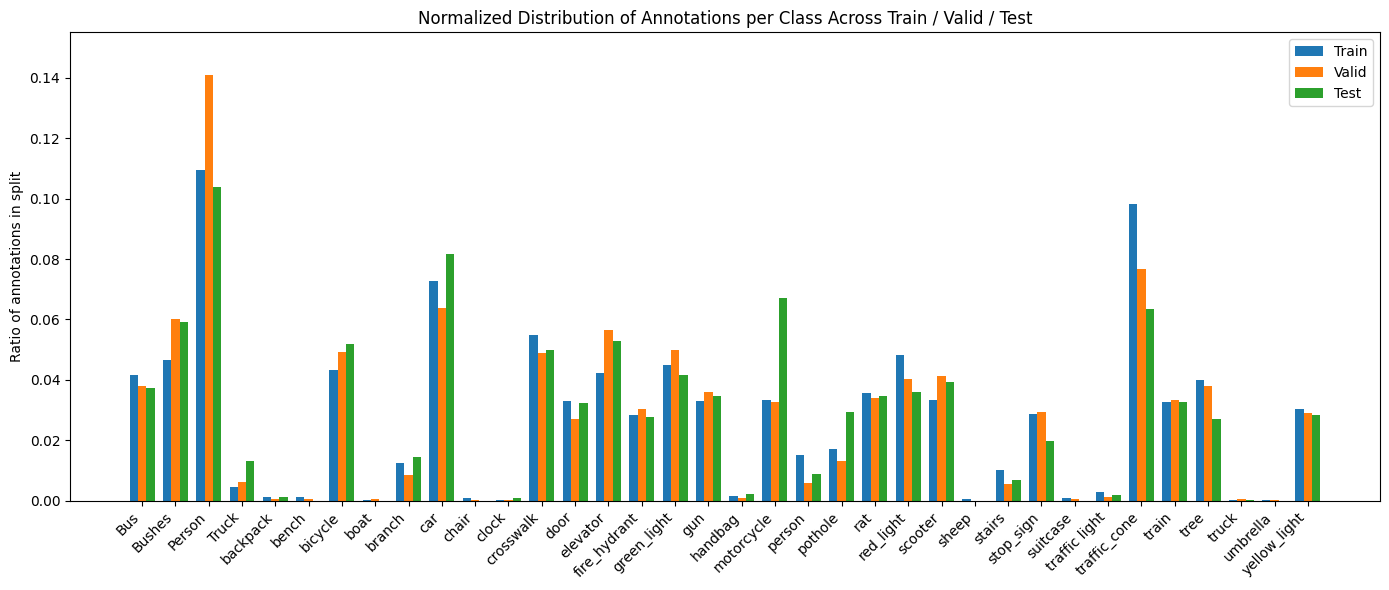

In [ ]:
# Combine counts in a dataframe
ann_df = pd.DataFrame({
    "train": train_ann_counts,
    "valid": valid_ann_counts,
    "test": test_ann_counts
})

# Ensure all classes are present across splits
ann_df = ann_df.fillna(0)

# Compute ratios: annotations per class / total annotations in that split
ratio_df = ann_df.div(ann_df.sum(axis=0), axis=1)

def plot_annotations_ratios(ratio_df):
    classes = ratio_df.index.tolist()
    x = np.arange(len(classes))
    width = 0.25

    plt.figure(figsize=(14,6))
    plt.bar(x-width, ratio_df["train"], width, label = "Train", color="tab:blue")
    plt.bar(x, ratio_df["valid"], width, label = "Valid", color="tab:orange")
    plt.bar(x+width, ratio_df["test"], width, label = "Test", color="tab:green")
    plt.xticks(x, classes, rotation=45, ha="right")
    plt.ylabel("Ratio of annotations in split")
    plt.title("Normalized Distribution of Annotations per Class Across Train / Valid / Test")
    plt.ylim(0, ratio_df.values.max() * 1.1)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_annotations(ratio_df)

The annotation ratios per split underpin the previous conclusion that annotations are balanced evenly across splits. 

### 2.6 Matrix of Co-occurence of classes across Train/Valid/Test

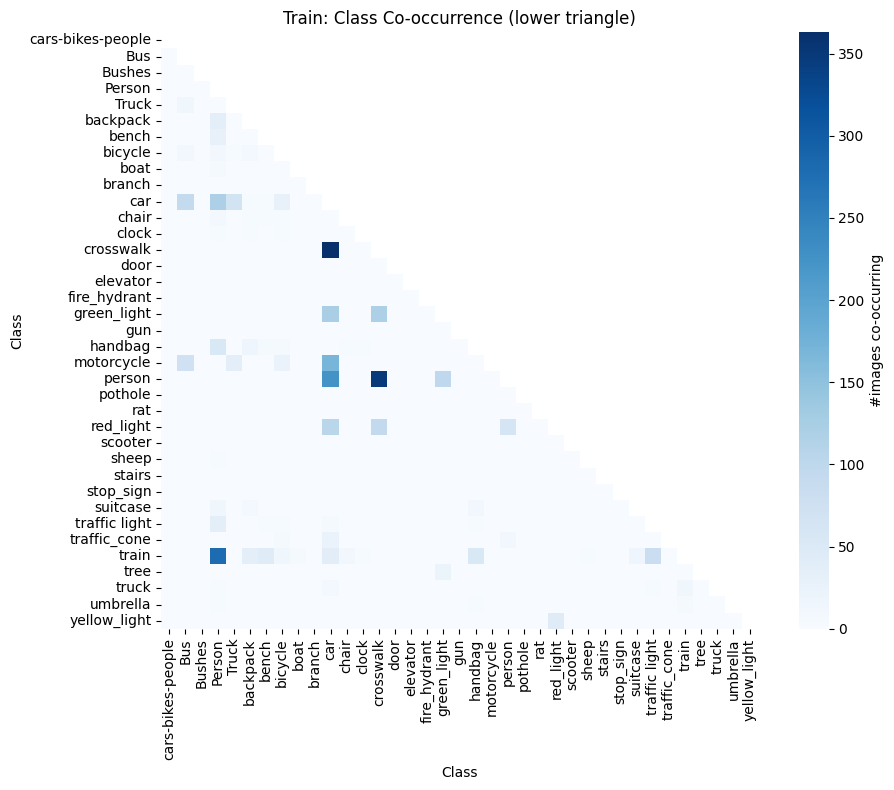

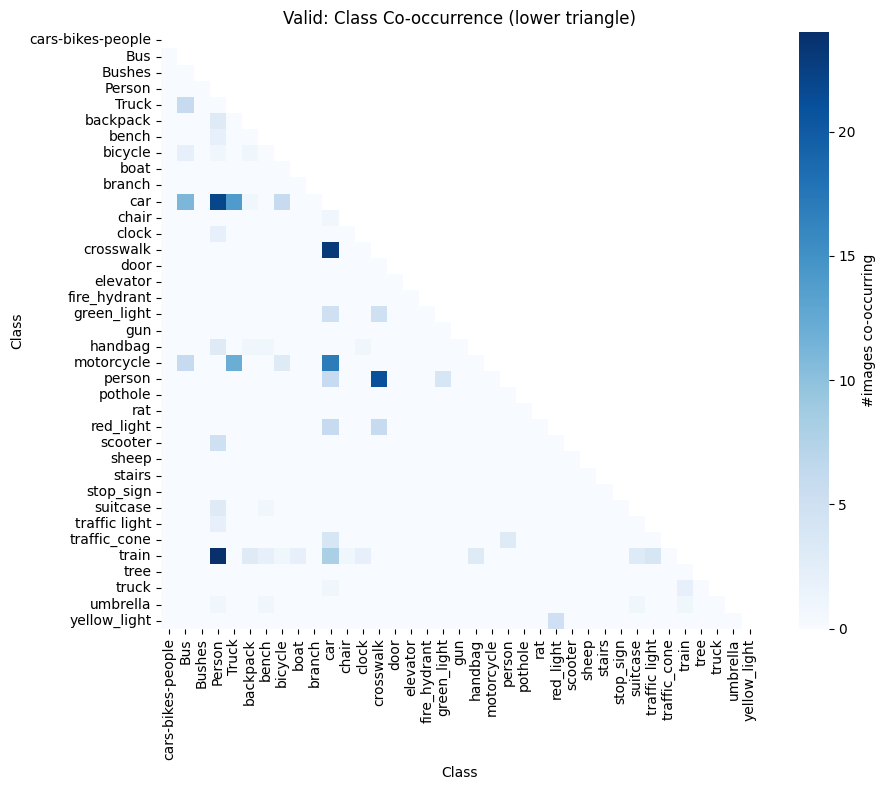

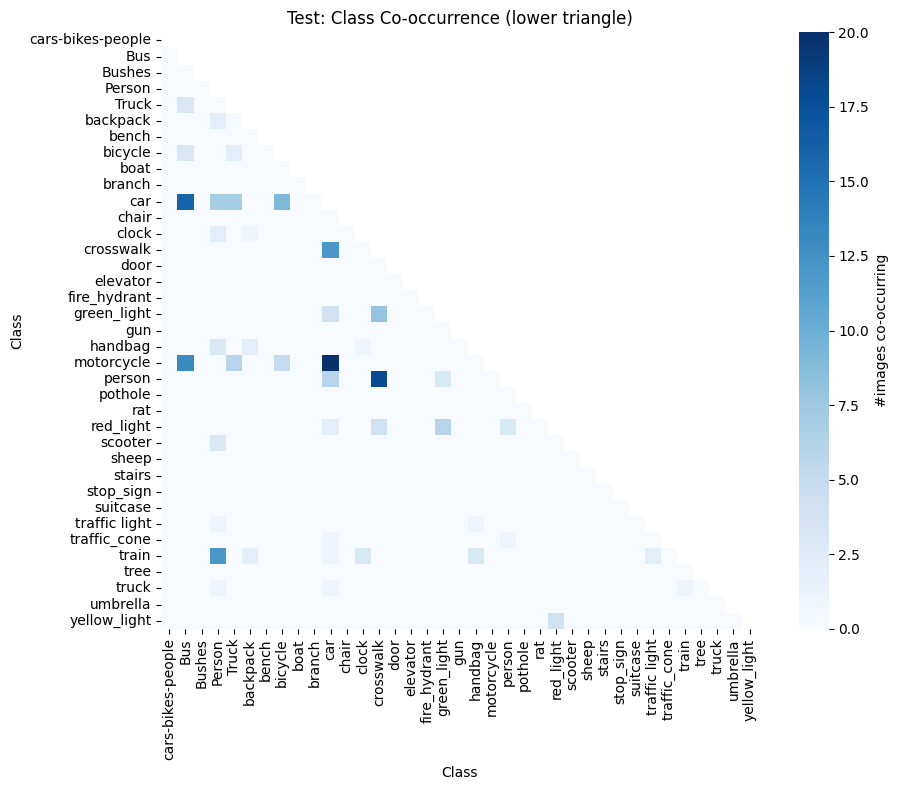

In [ ]:
def compute_cooccurrence(ann_df, categories_df):
    # Map category IDs to names
    categories_df = categories_df.sort_values("id")
    class_ids = categories_df["id"].tolist()
    class_names = categories_df["name"].tolist()
    id_to_idx = {cid: i for i, cid in enumerate(class_ids)}

    # For each image, get unique category_ids present
    img_to_classes = (
        ann_df.groupby("image_id")["category_id"]
        .apply(lambda x: sorted(set(x)))
    )

    n_classes = len(class_ids)
    co_mat = np.zeros((n_classes, n_classes), dtype=int)

    for classes in img_to_classes:
        idxs = [id_to_idx[cid] for cid in classes]
        for i in idxs:
            for j in idxs:
                co_mat[i, j] += 1 # counts images where i and ja co-occur
    co_df = pd.DataFrame(co_mat, index=class_names, columns=class_names)
    return co_df

def plot_cooccurence(co_df, title):
    mask = np.triu(np.ones_like(co_df, dtype = bool), k=0)

    plt.figure(figsize=(10,8))
    sns.heatmap(
        co_df, 
        mask = mask,
        square = True,
        cmap = "Blues",
        cbar_kws={"label": "#images co-occurring"},
    )
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Class")
    plt.tight_layout()
    plt.show()

train_co = compute_cooccurrence(train_ann, train_cat)
valid_co = compute_cooccurrence(valid_ann, valid_cat)
test_co  = compute_cooccurrence(test_ann,  test_cat)

plot_cooccurence(train_co, "Train: Class Co-occurrence (lower triangle)")
plot_cooccurence(valid_co, "Valid: Class Co-occurrence (lower triangle)")
plot_cooccurence(test_co,  "Test: Class Co-occurrence (lower triangle)")

### 2.6.1 Analysis of Co-Occurence
- Dominant co-occuring pairs: Car & Bus, Motorcylce & Buss, Person & Train, Motorcycle & Car, Crosswalk & Person are all frequently occuring paires which makes sense given the images are traffic related. Most classes however appear mainly isolated. 
- Implications: the model may learn to overfit to frequent object combinations whilst rare combinations may suffer from prro contextual understanding due to limited co-occurence. 

Sampling strategies or class-balanced training could help. 

### 2.7 Absolute and Relative Numbers of Objects per Image across Train/Valid/Test

In [4]:
def bucket_counts(ann_df, imgs_df):
    # Count annotations per image_id
    counts = ann_df["image_id"].value_counts()
    all_image_ids = imgs_df["id"].unique()
    counts = counts.reindex(all_image_ids, fill_value=0)

    # Define bins
    bins = [-0.1, 0, 5, 10, 20, 35, 50, np.inf]
    labels = [
        "0 objects",
        "1-5 objects",
        "5-10 objects",
        "10-20 objects",
        "20-35 objects", 
        "35-50 objects",
        "50+ objects",
    ]

    bucketed = pd.cut(counts.values, bins = bins, labels = labels)
    summary = pd.Series(bucketed).value_counts(sort=False).reindex(labels).fillna(0).astype(int)
    return summary

train_buckets = bucket_counts(train_ann, train_imgs)
valid_buckets = bucket_counts(valid_ann, valid_imgs)
test_buckets  = bucket_counts(test_ann,  test_imgs)

# Combine into a single dataframe
objects_summary = pd.DataFrame(
    [train_buckets, valid_buckets, test_buckets],
    index= ["Train", "Valid", "Test"]
)
print("Absolute Number of Objects per Image: ")
display(objects_summary)

relative_df = objects_summary.div(objects_summary.sum(axis=1), axis=0) * 100
relative_df = relative_df.round(2)
print("Relative Number of Objects per Image: ")
display(relative_df)

Absolute Number of Objects per Image: 


,0 objects,1-5 objects,5-10 objects,10-20 objects,20-35 objects,35-50 objects,50+ objects
Train,567,30807,738,306,69,12,12
Valid,57,4065,70,33,11,7,3
Test,36,2045,49,25,7,1,2


Relative Number of Objects per Image: 


,0 objects,1-5 objects,5-10 objects,10-20 objects,20-35 objects,35-50 objects,50+ objects
Train,1.74,94.76,2.27,0.94,0.21,0.04,0.04
Valid,1.34,95.74,1.65,0.78,0.26,0.16,0.07
Test,1.66,94.46,2.26,1.15,0.32,0.05,0.09


### 2.7.1 Analysis Number of Objects per Image
The analysis shows that their exist images with no annotations. Which matches a previous analysis. Mainly objects appear 1-5 times. The fewer objects per image the easier for the model to comprehend with fewer parameters and epochs. 

## 3. Data Cleaning

In [ ]:
def coco_to_xyxy(bbox):
    # COCO [x, y, w, h] -> [x1, y1, x2, y2]
    x, y, w, h = bbox
    return x, y, x + w, y + h

def iou_xyxy(box1, box2):
    # IoU between two boxes in [x1, y1, x2, y2] format
    x1, y1, x2, y2 = box1
    x1b, y1b, x2b, y2b = box2

    inter_x1 = max(x1, x1b)
    inter_y1 = max(y1, y1b)
    inter_x2 = min(x2, x2b)
    inter_y2 = min(y2, y2b)

    inter_w = max(0.0, inter_x2 - inter_x1)
    inter_h = max(0.0, inter_y2 - inter_y1)
    inter_area = inter_w * inter_h
    if inter_area == 0:
        return 0.0
    
    area1 = (x2 - x1) * (y2 -y1)
    area2 = (x2b - x1b) * (y2b - y1b)
    union = area1 + area2 - inter_area
    if union <= 0:
        return 0.0
    return inter_area / union

def clean_annotations(ann_df, imgs_df, iou_threshold: float = 0.9):
    ann = ann_df.copy()

    # 1. Validate bbox coordinates
    merged = ann.merge(
        imgs_df[["id", "width", "height"]],
        left_on="image_id",
        right_on="id",
        how="left",
        suffixes=("", "_img")
    )

    # Extract x1, y1, x2, y2
    bbox_xyxy = merged["bbox"].apply(coco_to_xyxy)
    merged[["x1", "y1", "x2", "y2"]] = pd.DataFrame(bbox_xyxy.tolist(), index=merged.index)

    # COnditions for validity
    valid = (
        (merged["x2"] > merged["x1"]) &
        (merged["y2"] > merged["y1"]) &
        (merged["x1"] >= 0) &
        (merged["y1"] >= 0) &
        (merged["x2"] <= merged["width"]) &
        (merged["y2"] <= merged["height"])
    )

    num_invalid = (~valid).sum()
    if num_invalid > 0:
        print(f"[INFO] Removing {num_invalid} invalid boxes (out-of-bounds or non-positive size).")
    merged_valid = merged[valid].copy()

    # 2. Remove near-duplicates (same image_id + category_id, IoU >= threshold)
    to_drop_idx = set()
    groups = merged_valid.groupby(["image_id", "category_id"])

    for (_, _), group in groups:
        if len(group) <= 1:
            continue

        # Precompute boxes in xyxy format
        boxes = group[["x1", "y1", "x2", "y2"]].to_numpy()
        idxs = group.index.to_list()

        keep_mask = [True] * len(idxs)

        for i in range(len(idxs)):
            if not keep_mask[i]:
                continue
            for j in range(i + 1, len(idxs)):
                if not keep_mask[j]:
                    continue
                iou = iou_xyxy(boxes[i], boxes[j])
                if iou >= iou_threshold:
                    # mark j as duplicate of i
                    keep_mask[j] = False
                    to_drop_idx.add(idxs[j])

    if to_drop_idx:
        print(f"[INFO] Removing {len(to_drop_idx)} near-duplicate boxes (IoU >= {iou_threshold}).")
    
    cleaned = merged_valid.drop(index=list(to_drop_idx))
    # Drop helper columns and restore original annotation schema
    cleaned = cleaned[ann_df.columns]
    cleaned = cleaned.reset_index(drop=True)
    print(f"[INFO] Annotations before: {len(ann_df)}, after cleaning: {len(cleaned)}")
    return cleaned

train_ann_clean = clean_annotations(train_ann, train_imgs, iou_threshold=0.9)
valid_ann_clean = clean_annotations(valid_ann, valid_imgs, iou_threshold=0.9)
test_ann_clean  = clean_annotations(test_ann,  test_imgs,  iou_threshold=0.9)

[INFO] Removing 489 invalid boxes (out-of-bounds or non-positive size).
[INFO] Removing 108 near-duplicate boxes (IoU >= 0.9).
[INFO] Annotations before: 54480, after cleaning: 53883
[INFO] Removing 67 invalid boxes (out-of-bounds or non-positive size).
[INFO] Removing 31 near-duplicate boxes (IoU >= 0.9).
[INFO] Annotations before: 7255, after cleaning: 7157
[INFO] Removing 33 invalid boxes (out-of-bounds or non-positive size).
[INFO] Removing 15 near-duplicate boxes (IoU >= 0.9).
[INFO] Annotations before: 3730, after cleaning: 3682


### 3.1 Analysis of Data Cleaning
- Annotations contain a small but non-negligible amount of noise, where boxes are either geometrically invalid or overly redundant
- It appears that objects were occasionally double-labeled as seen by the IoU duplicates
- Noise levels appear to be consistent across the splits

Cleaning explicitly removed a few bad or redundant boxes without meaningfully shrinking the size of the dataset. This should have a positive affect on training. 

## 4. Data Preprocessing
### 4.1 Create YOLO Dataset
YOLO expects the first class to be 0, the next 1, etc., and uses that index to look up the class name
We create a deterministic mapping to YOLO class indices. 

In [ ]:
cat_df = train_cat.sort_values("id")
cat_ids = cat_df["id"].tolist()
cat_nams = cat_df["name"].tolist()
cat_id_to_yolo = {cid: idx for idx, cid in enumerate(cat_ids)}

print("Class mapping (Coco id to YOLO id):")
for cid, yid in cat_id_to_yolo.items():
    cname = cat_df.loc[cat_df["id"] == cid, "name"].iloc[0]
    print(f"{cid:>3} ({cname}) -> {yid}")

def coco_bbox_to_yolo(bbox, img_width, img_height):
    x,y,w,h = bbox
    x_c = x + w / 2.0
    y_c = y + h / 2.0

    return [
        x_c / img_width,
        y_c / img_height,
        w / img_width,
        h / img_height,
    ]

def convert_split_to_yolo(
    split_name: str,
    imgs_df: pd.DataFrame,
    ann_df_clean: pd.DataFrame,
    yolo_root: Path,
):
    # yolo_root: root folder for new YOLO dataset
    print(f"\nConverting split: {split_name}")

    # Yolo subfolders
    images_dst_dir = yolo_root / "images" / split_name
    labels_dst_dir = yolo_root / "labels" / split_name
    images_dst_dir.mkdir(parents=True, exist_ok=True)
    labels_dst_dir.mkdir(parents=True, exist_ok=True)

    # Map image_id to filename, width, height
    imgs_info = imgs_df.set_index("id")[["file_name", "width", "height"]]
    ann_by_image = ann_df_clean.groupby("image_id")

    for img_id, row in imgs_info.iterrows():
        file_name = row["file_name"]
        img_w = row["width"]
        img_h = row["height"]

        # Source and destination image paths
        src_img_path = BASE_DIR / split_name / file_name
        dst_img_path = images_dst_dir /file_name

        if not dst_img_path.exists():
            shutil.copy2(src_img_path, dst_img_path)
        label_path = labels_dst_dir / (Path(file_name).stem + ".txt")

        lines = []
        if img_id in ann_by_image.groups:
            anns = ann_by_image.get_group(img_id)
            for _, ann in anns.iterrows():
                cat_id = ann["category_id"]
                yolo_cls = cat_id_to_yolo[cat_id]
                bbox = ann["bbox"]
                x_c, y_c, w_norm, h_norm = coco_bbox_to_yolo(bbox, img_w, img_h)
                lines.append(
                    f"{yolo_cls} {x_c:.6f} {y_c:.6f} {w_norm:.6f} {h_norm:.6f}"
                )
        # Write label file (empty file if no annotations)
        with open(label_path, "w") as f: 
            if lines:
                f.write("\n".join(lines))
    print(f"[DONE] Split '{split_name}' converted to YOLO format.")
WORKING_DIR = Path("/kaggle/working/")
yolo_root = WORKING_DIR / "yolo_dataset"
yolo_root.mkdir(exist_ok=True)

convert_split_to_yolo("train", train_imgs, train_ann_clean, yolo_root)
convert_split_to_yolo("valid", valid_imgs, valid_ann_clean, yolo_root)
convert_split_to_yolo("test",  test_imgs,  test_ann_clean,  yolo_root)

Class mapping (COCO id -> YOLO id):
    0 (cars-bikes-people) -> 0
    1 (Bus) -> 1
    2 (Bushes) -> 2
    3 (Person) -> 3
    4 (Truck) -> 4
    5 (backpack) -> 5
    6 (bench) -> 6
    7 (bicycle) -> 7
    8 (boat) -> 8
    9 (branch) -> 9
   10 (car) -> 10
   11 (chair) -> 11
   12 (clock) -> 12
   13 (crosswalk) -> 13
   14 (door) -> 14
   15 (elevator) -> 15
   16 (fire_hydrant) -> 16
   17 (green_light) -> 17
   18 (gun) -> 18
   19 (handbag) -> 19
   20 (motorcycle) -> 20
   21 (person) -> 21
   22 (pothole) -> 22
   23 (rat) -> 23
   24 (red_light) -> 24
   25 (scooter) -> 25
   26 (sheep) -> 26
   27 (stairs) -> 27
   28 (stop_sign) -> 28
   29 (suitcase) -> 29
   30 (traffic light) -> 30
   31 (traffic_cone) -> 31
   32 (train) -> 32
   33 (tree) -> 33
   34 (truck) -> 34
   35 (umbrella) -> 35
   36 (yellow_light) -> 36

=== Converting split: train ===
[DONE] Split 'train' converted to YOLO format.

=== Converting split: valid ===
[DONE] Split 'valid' converted to YOLO form

In [ ]:
data_yaml = {
    "path": str(yolo_root.resolve()),
    "train": "images/train",
    "val": "images/valid",
    "test": "images/test",
    "names": {i: name for i, name in enumerate(cat_names)}
}

yaml_path = yolo_root / "coco26_yolo.yaml"
with open(yaml_path, "w") as f: 
    yaml.dump(data_yaml, f, sort_keys=False)
print("Wrote dataset YAML to:", yaml_path)

Wrote dataset YAML to: /kaggle/working/yolo_dataset/coco26_yolo.yaml


### 4.2 Creating Subset for Training
Given the large dataset and the fact that this exploration can be seen as a proof of concept and subset will be used for training in order to reduce memory usage and training time. 

In [ ]:
def create_subset(yolo_root, subset_root, fraction=0.1):
    subset_root = Path(subset_root)
    subset_root.mkdir(parents=True, exist_ok=True)

    for split in ["train", "valid", "test"]:
        imgs_dir = Path(yolo_root) / "images" / split
        lbls_dir = Path(yolo_root) / "labels" / split
        imgs_subset = subset_root / "images" / split
        lbls_subset = subset_root / "images" / split
        imgs_subset.mkdir(parents=True, exist_ok=True)
        lbls_subset.mkdir(parents=True, exist_ok=True)

        img_files = list(imgs_dir.glob("*.jpg"))
        n_keep = max(1, int(len(img_files) * fraction))
        keep_files = random.sample(img_files, n_keep)

        for img in keep_files:
            shutil.copy2(img, imgs_subset / img.name)
            lbl = lbls_dir / (img.stem + ".txt")
            shutil.copy2(lbl, lbls_subset / lbl.name)
    
    print("Subset created at: ", subset_root)

create_subset(yolo_root="yolo_dataset", subset_root="yolo_dataset_subset10", fraction=0.10)

Subset created at: yolo_dataset_subset10


In [ ]:
subset_yaml = {
    "path": "yolo_dataset_subset10",
    "train": "images/train", 
    "val": "images/valid",
    "test": "images/test",
    "names": data_yaml["names"]
}

with open("coco26_subset10.yaml", "w") as f: 
    yaml.dump(subset_yaml, f, sort_keys = False)
print("Wrote subset YAML to:", yaml_path)

Wrote subset YAML to: /kaggle/working/yolo_dataset/coco26_yolo.yaml


### 4.3 Check for GPU Availability 

In [ ]:
print("GPU Availability Check")
print("Torch CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("Torch CUDA version:", torch.version.cuda)
    print("Current device:", torch.cuda.get_device_name(0))
    print("Memory allocated (GB):", round(torch.cuda.memory_allocated(0) / 1024**3, 2))
    print("Memory reserved  (GB):", round(torch.cuda.memory_reserved(0)  / 1024**3, 2))

    # nvidia-smi output
    print("\nNVIDIA-SMI")
    subprocess.run(["nvidia-smi"], check=False)
else:
    print("No GPU detected!")

GPU Availability Check
Torch CUDA available: True
Torch CUDA version: 12.4
Current device: Tesla T4
Memory allocated (GB): 0.0
Memory reserved  (GB): 0.0

NVIDIA-SMI
Sun Nov 30 16:34:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8             12W /   70W |       3MiB /  15360MiB

## 5. Modeling
#### Architecture of YOLOv8n (Nano Model)
- This model uses a very small feature extractor at the beginning. It looks at the raw image and turns it into a set of visual patterns (edges, textures, shapes). Because it is small, it works fast but cannot learn subtle or highly complex details
- After the feature extractor, the model has a multi-scale fusion stage. Here it combines information from large shapes and fine details to help it better detect both big and small objects
- The final section is a prediction head which predict the center, width, and height of each object box and the object type

#### Architecture of YOLOv8s (Small Model)
- This model works similarly Nano model but uses a large feature extractor with more layers, to allow it to understand the image in greater depth
- The multi scale fusion stage is also larger and can combine information from different image resolutions more effectively. This also helps it to detect object in cluttered scenes. 
- The prediction head has more capacity. It can perform finer adjusting of bounding boxes and make more confident decisions about object types. 

### 5.1 Train Yolov8n model

In [ ]:
model = YOLO("yolov8n.pt")
model.train(
    data = "coco26_subset10.yaml",
    epochs = 20,
    imgsz = 512,
    batch = 32,
    workers = 4, 
    cache = True, 
    device = 0,
    patience = 5, 
    project ="runs/26ClassObjectDetection_yolov8n_t4",
    name = "dev_subset"
)

### 5.1.1 Plot Train and Validation Losses for YOLOv8n

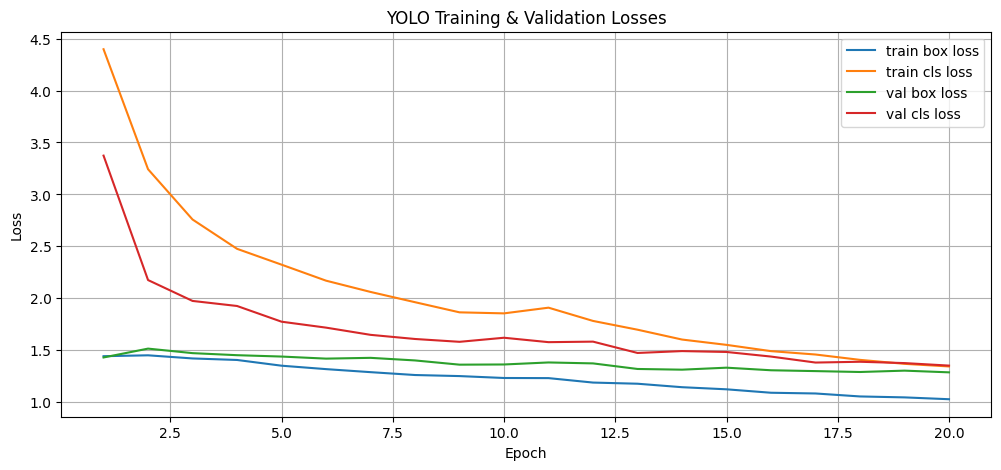

In [ ]:
df = pd.read_csv("/kaggle/working/runs/26ClassObjectDetection_yolov8n_t4/dev_subset/results.csv")

plt.figure(figsize=(12, 5))
plt.plot(df["epoch"], df["train/box_loss"], label = "train box loss")
plt.plot(df["epoch"], df["train/cls_loss"], label = "train cls loss")
plt.plot(df["epoch"], df["val/box_loss"], label = "val box loss")
plt.plot(df["epoch"], df["val/cls_loss"], label = "val cls loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("YOLO Training & Validation Losses")
plt.legend()
plt.grid()
plt.show()

### Analysis of YOLOv8n: 
- Healthly overall convergence: all four losses steadily decrease oveer 20 epochs
- Box regression: given the very slight decrease it appears the model may need more epochs or stronger augmentation to refine localization

Small bumps or oscillations are normal and indicate dataset variability. 

### 5.2 Train YOLOv8s Model

In [ ]:
df = pd.read_csv("/kaggle/working/runs/26ClassObjectDetection_yolov8n_t4/dev_subset/results.csv")

plt.figure(figsize=(12, 5))
plt.plot(df["epoch"], df["train/box_loss"], label = "train box loss")
plt.plot(df["epoch"], df["train/cls_loss"], label = "train cls loss")
plt.plot(df["epoch"], df["val/box_loss"], label = "val box loss")
plt.plot(df["epoch"], df["val/cls_loss"], label = "val cls loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("YOLO Training & Validation Losses")
plt.legend()
plt.grid()
plt.show()

### 5.2.1 Plot Train and Validation Losses for YOLOv8s Model

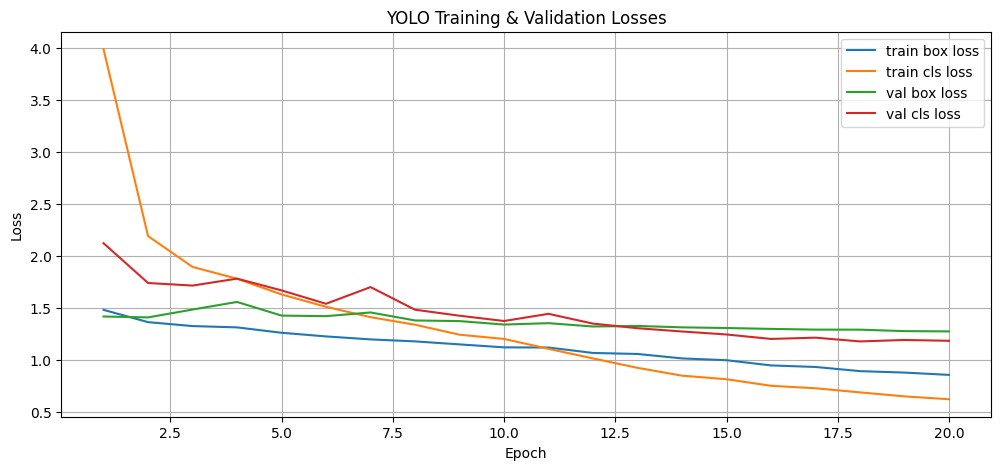

In [ ]:
df = pd.read_csv("/kaggle/working/runs/26ClassObjectDetection_yolov8s_t4/dev_subset/results.csv")

plt.figure(figsize=(12, 5))
plt.plot(df["epoch"], df["train/box_loss"], label = "train box loss")
plt.plot(df["epoch"], df["train/cls_loss"], label = "train cls loss")
plt.plot(df["epoch"], df["val/box_loss"], label = "val box loss")
plt.plot(df["epoch"], df["val/cls_loss"], label = "val cls loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("YOLO Training & Validation Losses")
plt.legend()
plt.grid()
plt.show()

### Analysis of YOLOv8s
- The model does not appear to have fully converged and suggests mild underfitting most likely improvable with more epochs or adjusted augmentation

### 5.3 Compare and Evaluate both Models on the Validation Set

In [ ]:
def get_class_metrics(model):
    metrics = model.val(
        data = "coco26_subset10.yaml",
        split = "val"
    )
    class_names = model.names
    box = metrics.box
    nc = len(box.p)

    rows = []
    for i in range(nc):
        p_i, r_i, ap50_i, ap_i = box.class_result(i)
        rows.append({
            "class_id": i,
            "class_name": class_names[i],
            "precision": p_i,
            "recall": r_i,
            "AP50": ap50_i,
            "AP50-95": ap_i,
        })
    return pd.DataFrame(rows)

model_n = YOLO("/kaggle/working/runs/26ClassObjectDetection_yolov8n_t4/dev_subset/weights/best.pt")
model_s = YOLO("/kaggle/working/runs/26ClassObjectDetection_yolov8s_t4/dev_subset/weights/best.pt")

df_n = get_class_metrics(model_n)
df_s = get_class_metrics(model_s)

Ultralytics 8.3.233 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,012,863 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 607.4±163.3 MB/s, size: 16.0 KB)
val: Scanning /kaggle/working/yolo_dataset_subset10/labels/valid.cache... 798 images, 7 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 798/798 1.8Mit/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 8.9it/s 5.6s<0.1s
                   all        798       1483      0.598      0.495      0.514      0.347
                   Bus         46         52      0.773      0.721        0.8      0.655
                Bushes         34         73      0.857      0.438      0.451        0.3
                Person         49        388      0.234     0.0541      0.076     0.0389
                 Truck         10         10          1      0.571      0.698       0.56
               bicycle 

In [ ]:
df_compare = df_n.merge(df_s, on = ["class_id", "class_name"], suffixes=("_8n", "_8s"))
df_compare = df_compare[[
    "class_id",
        "class_name",
        "precision_8n", "precision_8s",
        "recall_8n", "recall_8s",
        "AP50_8n", "AP50_8s",
        "AP50-95_8n", "AP50-95_8s",
]]
df_compare

,class_id,class_name,precision_8n,precision_8s,recall_8n,recall_8s,AP50_8n,AP50_8s,AP50-95_8n,AP50-95_8s
0,0,cars-bikes-people,0.773256,0.805767,0.721500,0.718095,0.799896,0.821875,0.655077,0.668261
1,1,Bus,0.856835,0.897961,0.438356,0.493151,0.451198,0.517287,0.299895,0.344521
2,2,Bushes,0.234141,0.344611,0.054124,0.092784,0.076041,0.115192,0.038869,0.053273
3,3,Person,1.000000,0.830723,0.571424,0.600000,0.698406,0.689698,0.559733,0.552683
4,4,Truck,0.631069,0.685339,0.678571,0.732143,0.678978,0.663684,0.430379,0.417661
5,5,backpack,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,6,bench,0.470056,0.289121,0.090909,0.052568,0.179712,0.117257,0.103835,0.083658
7,7,bicycle,0.586418,0.614240,0.588235,0.661765,0.582570,0.669119,0.466755,0.519032
8,8,boat,0.870537,0.914276,0.750000,0.841999,0.797296,0.926595,0.527767,0.596624
9,9,branch,0.650087,0.730586,0.920000,0.960000,0.899269,0.909344,0.687588,0.722444


#### Analysis
- Precision measure the proportion of a model's detections that are correct and reflects the model's ability to avoid false positives
- Recall: measure the proportion of ground-truth objects that the model successfully detects and capture the model's ability to avoid false negatives
- AP50: the average precision at an intersection over union threshold of 0.50. A detection is considered correct it its predicted bounding box overlaps the ground truth by at least 50%
- AP50-95: average precision averaged over IoU thresholds from 0.50 to 0.95 in increments and captures how well the model performs across a range of localization requirements. It's widely regarded and the most informative sinlge indicator for object detection quality

### 5.3.1 Plot Comparisons of Precision, Recall, AP50, AP50-95

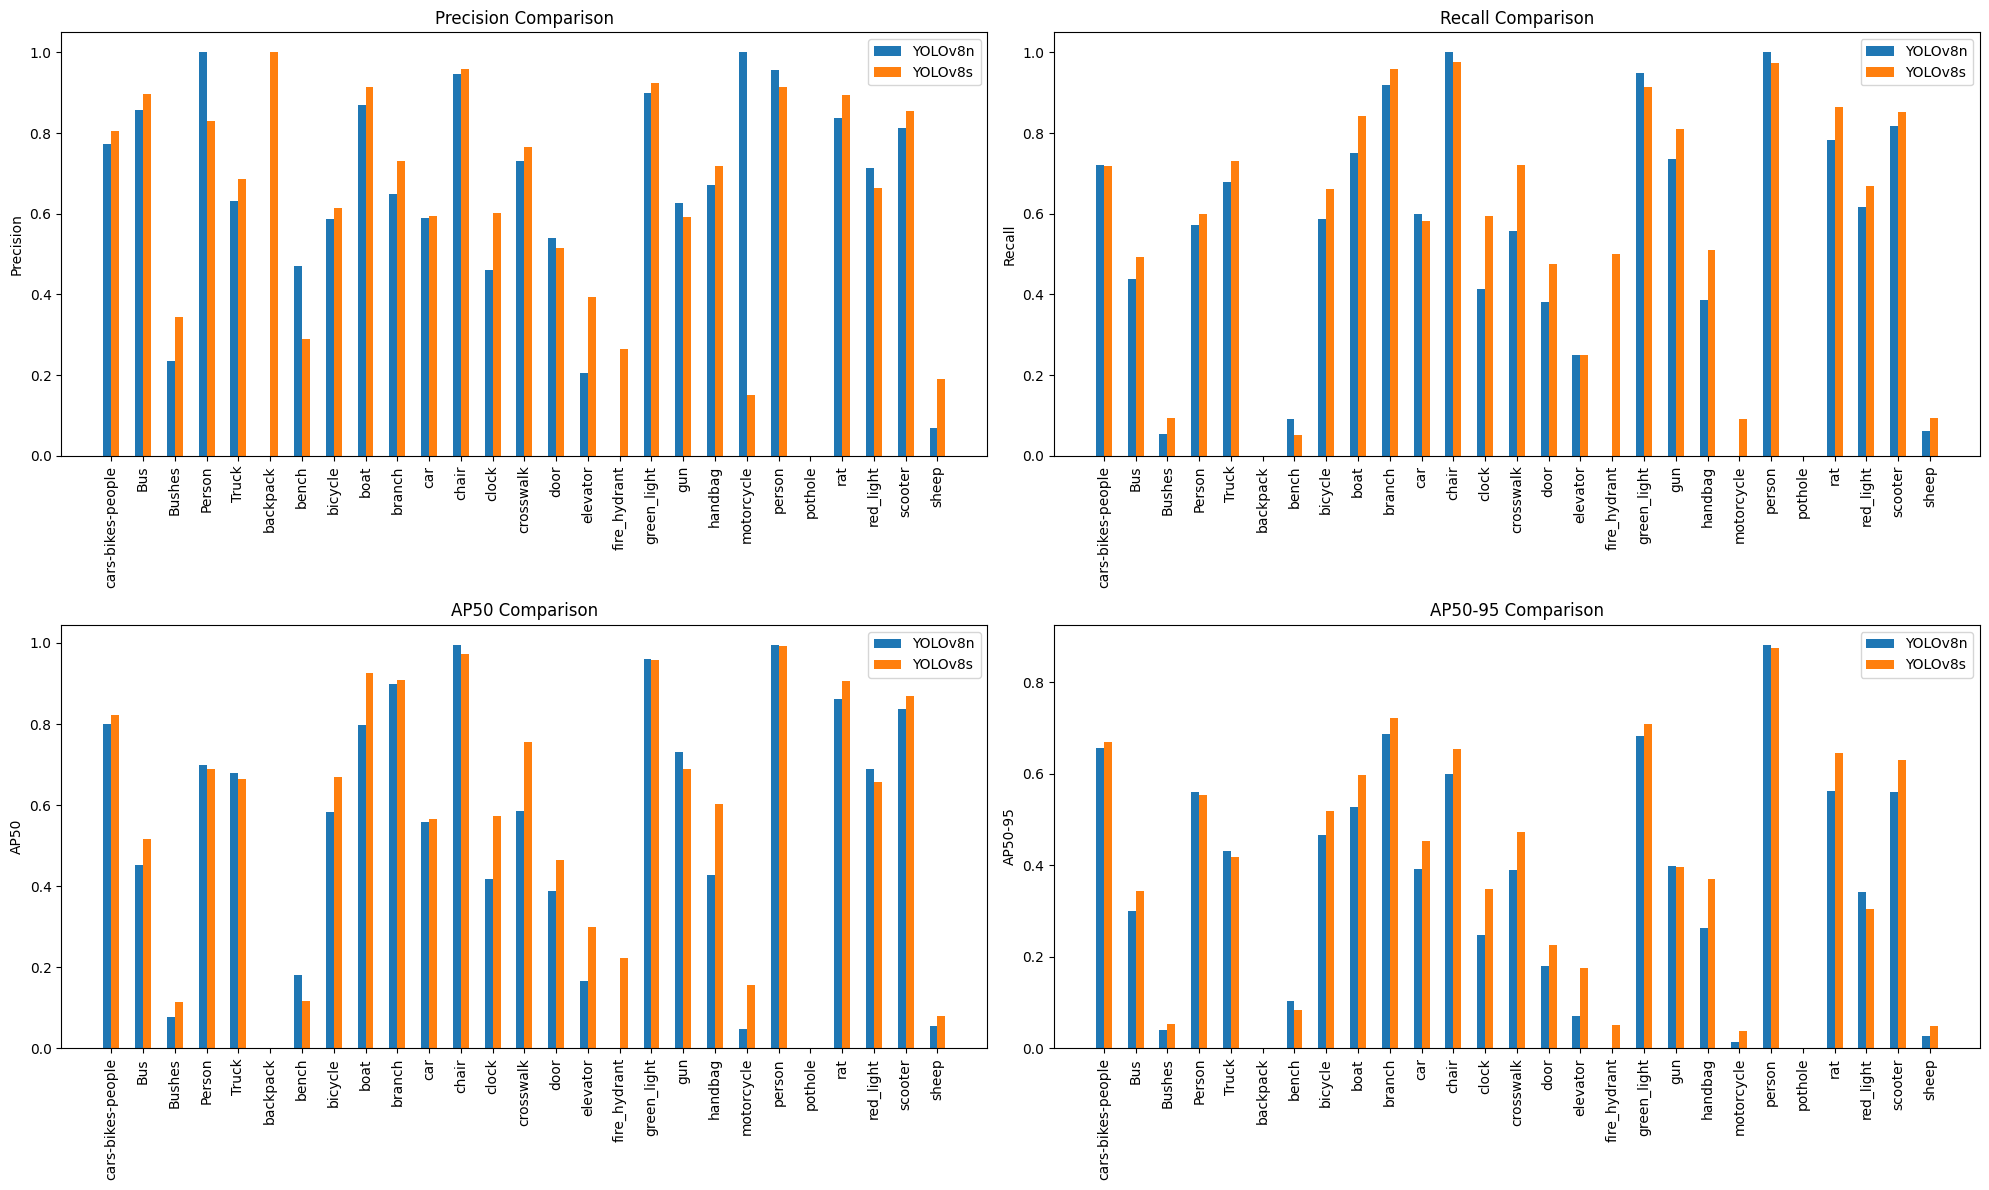

In [ ]:
x = np.arange(len(df_compare))

fig, axes = plt.subplots(2, 2, figsize=20,12))
axes = axes.ravel()
width = 0.25

# Precision
axes[0].bar(x - width/2, df_compare["precision_8n"], width, label="YOLOv8n")
axes[0].bar(x + width/2, df_compare["precision_8s"], width, label="YOLOv8s")
axes[0].set_title("Precision Comparison")
axes[0].set_ylabel("Precision")
axes[0].set_xticks(x)
axes[0].set_xticklabels(df_compare["class_name"], rotation=90)
axes[0].legend()

# Recall
axes[1].bar(x - width/2, df_compare["recall_8n"], width, label="YOLOv8n")
axes[1].bar(x + width/2, df_compare["recall_8s"], width, label="YOLOv8s")
axes[1].set_title("Recall Comparison")
axes[1].set_ylabel("Recall")
axes[1].set_xticks(x)
axes[1].set_xticklabels(df_compare["class_name"], rotation=90)
axes[1].legend()

# AP50
axes[2].bar(x - width/2, df_compare["AP50_8n"], width, label="YOLOv8n")
axes[2].bar(x + width/2, df_compare["AP50_8s"], width, label="YOLOv8s")
axes[2].set_title("AP50 Comparison")
axes[2].set_ylabel("AP50")
axes[2].set_xticks(x)
axes[2].set_xticklabels(df_compare["class_name"], rotation=90)
axes[2].legend()

# AP50-95
axes[3].bar(x - width/2, df_compare["AP50-95_8n"], width, label="YOLOv8n")
axes[3].bar(x + width/2, df_compare["AP50-95_8s"], width, label="YOLOv8s")
axes[3].set_title("AP50-95 Comparison")
axes[3].set_ylabel("AP50-95")
axes[3].set_xticks(x)
axes[3].set_xticklabels(df_compare["class_name"], rotation=90)
axes[3].legend()

plt.tight_layout()
plt.show()

### Analysis: 
YOLOv8s appears to outperform YOLOv8n across most classes, indicating that the model with more parameters is better suited to this dataset's class distribution and scale. 
- Both models show large per-class variance, with certain classes performing poorly, highlighting dataset imbalance and inconsistent representation

### 5.3.2 Per Class and Global Winner

In [ ]:
def winner(n, s):
    if np.isclose(n, s):
        return "Tie"
    return "v8s" if s > n else "v8n"

df_winners = pd.DataFrame({
    "class_name": df_compare["class_name"],
    "precision_winner": [
        winner(n, s) for n, s in zip(df_compare["precision_8n"], df_compare["precision_8s"])
    ],
    "recall_winner": [
        winner(n, s) for n, s in zip(df_compare["recall_8n"], df_compare["recall_8s"])
    ],
    "AP50_winner": [
        winner(n, s) for n, s in zip(df_compare["AP50_8n"], df_compare["AP50_8s"])
    ],
    "AP50-95_winner": [
        winner(n, s) for n, s in zip(df_compare["AP50-95_8n"], df_compare["AP50-95_8s"])
    ],
})

def highlight_v8s(val):
    if val == "v8s":
        return "background-colog: orange;"
    return ""

display(df_winners.style.map(highlight_v8s))
metric_columns = ["precision_winner", "recall_winner", "AP50_winner", "AP50-95_winner"]

global_counts = (
    df_winners[metric_columns].apply(pd.Series.value_counts)
)
v8s_total = (df_winners[metric_columns] == "v8s").sum().sum()
v8n_total = (df_winners[metric_columns] == "v8n").sum().sum()

if v8s_total > v8n_total:
    print("Global Winner: YOLOv8s")
elif v8n_total > v8s_total:
    print("Global Winner: YOLOv8n")
else:
    print("Global Result: Tie")

,class_name,precision_winner,recall_winner,AP50_winner,AP50-95_winner
0,cars-bikes-people,v8s,v8n,v8s,v8s
1,Bus,v8s,v8s,v8s,v8s
2,Bushes,v8s,v8s,v8s,v8s
3,Person,v8n,v8s,v8n,v8n
4,Truck,v8s,v8s,v8n,v8n
5,backpack,v8s,tie,tie,tie
6,bench,v8n,v8n,v8n,v8n
7,bicycle,v8s,v8s,v8s,v8s
8,boat,v8s,v8s,v8s,v8s
9,branch,v8s,v8s,v8s,v8s


Global Winner: YOLOv8s


The better performing model is YOLOv8s, which makes sense given the architectures of both models. However, their exist classes where the nano model outperformed. Further investigation is necessary to identify reasons for this. 

## 6. Hyperparameter Tuning the Global Winner (YOLOv8s)

In [ ]:
random.seed(42)
np.random.seed(42)

BASE_MODEL = "/kaggle/working/runs/26ClassObjectDetection_yolov8s_t4/dev_subset/weights/best.pt"  # or your own weights path
DATA_YAML = "/kaggle/working/coco26_subset10.yaml"

N_TRIALS = 8
EPOCHS = 30 # max epochs per trial
PATIENCE = 3 # early stopping patience (stop auf this many epochs without improvement)
PROJECT_NAME = "26Class_yolov8s_tuning_subset"
IMG_SIZE = 512
CACHE = True
BATCH_SIZE = 32
DEVICE = 0

def sample_hparams():
    """Sample a random hyperparameter configuration for YOLOv8."""
    lr0 = 10 ** np.random.uniform(-4, -2)

    return {
        "lr0": lr0,
        "lrf": np.random.uniform(0.01, 0.2),
        "momentum": np.random.uniform(0.85, 0.97),
        "weight_decay": np.random.uniform(1e-4, 1e-3),

        # loss balance
        "box": np.random.uniform(0.02, 0.1),
        "cls": np.random.uniform(0.2, 0.7),
        "dfl": np.random.uniform(0.5, 1.5),

        "hsv_h": np.random.uniform(0.0, 0.015),
        "hsv_s": np.random.uniform(0.4, 0.9),
        "hsv_v": np.random.uniform(0.4, 0.9),
        "degrees": np.random.uniform(0.0, 10.0),
        "scale": np.random.uniform(0.5, 1.0),
        "shear": np.random.uniform(0.0, 5.0),
        "translate": np.random.uniform(0.0, 0.2),
    }

results = []  # store trial results

for trial in range(N_TRIALS):
    print(f"\nTRIAL {trial+1}/{N_TRIALS}")

    hparams = sample_hparams()
    trial_name = f"trial_{trial:02d}"

    # Load a fresh model each trial, to ensure consistent weights
    model = YOLO(BASE_MODEL)

    # Train with early stopping (patience)
    model.train(
        data=DATA_YAML,
        epochs=EPOCHS,
        patience=PATIENCE,
        imgsz=IMG_SIZE,
        batch=BATCH_SIZE,
        project=PROJECT_NAME,
        name=trial_name,
        cache = CACHE,
        exist_ok=True,
        device=DEVICE,
        **hparams,
    )

    # Path to best weights of this trial
    trial_dir = os.path.join(PROJECT_NAME, trial_name)
    best_weights = os.path.join(trial_dir, "weights", "best.pt")

    # Re-load best model and evaluate on Validation set
    tuned_model = YOLO(best_weights)
    metrics = tuned_model.val(
        data=DATA_YAML,
        split="val",
        imgsz=IMG_SIZE,
        batch=BATCH_SIZE,
        device=DEVICE,
        verbose=False
    )

    # mAP50-95
    map_50_95 = metrics.box.map
    print(f"Trial {trial_name} mAP50-95: {map_50_95:.4f}")

    # Store results
    results.append({
        "trial": trial_name,
        "mAP50-95": map_50_95,
        "best_weights": best_weights,
        **hparams
    })

# Create DataFrame
df_tuning = pd.DataFrame(results)
df_tuning = df_tuning.sort_values("mAP50-95", ascending=False).reset_index(drop=True)
df_tuning


TRIAL 1/8
Ultralytics 8.3.233 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=0.03248149123539492, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.27799726016810133, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/coco26_subset10.yaml, degrees=0.20584494295802447, deterministic=True, device=0, dfl=0.5580836121681995, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.012992642186624027, hsv_s=0.7005575058716045, hsv_v=0.7540362888980228, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005611516415334504, lrf=0.19063571821788408, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/kaggle/working/runs/26ClassObjectDetection_yolo

In [ ]:
best_row = df_tuning.iloc[0]
print("\nBEST TRIAL:")
print(best_row[["trial", "mAP50-95", "best_weights"]])
print("\nBest hyperparameters:")
print(best_row.drop(labels=["trial", "mAP50-95", "best_weights"]))


BEST TRIAL:
trial                                                    trial_01
mAP50-95                                                 0.340625
best_weights    26Class_yolov8s_tuning_subset/trial_01/weights...
Name: 0, dtype: object

Best hyperparameters:
lr0             0.001252
lrf             0.145886
momentum        0.922332
weight_decay     0.00059
box             0.053892
cls             0.522947
dfl             0.937587
hsv_h           0.013377
hsv_s           0.881831
hsv_v           0.591721
degrees          7.91725
scale           0.764447
shear           2.840223
translate       0.185119
Name: 0, dtype: object


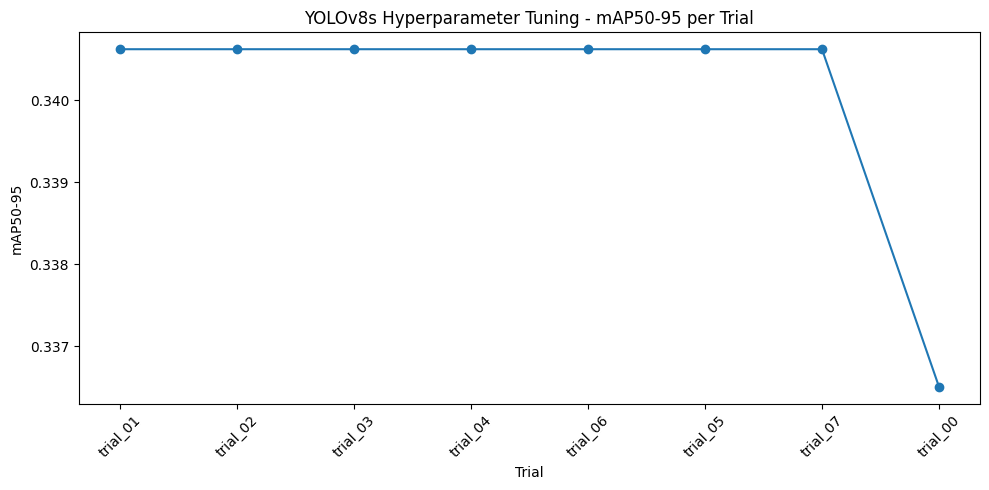

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(df_tuning["trial"], df_tuning["mAP50-95"], marker = "o")
plt.xticks(rotation=45)
plt.ylabel("mAP50-95")
plt.xlabel("Trial")
plt.title("YOLOv8s Hyperparameter Tuning - mAP50-95 per Trial")
plt.tight_layout()
plt.show()

## 7. Results and Analysis
### 7.1 Compare Tuned and Untuned Model on Validation Set

In [ ]:
model_s_untuned = YOLO("/kaggle/working/runs/26ClassObjectDetection_yolov8s_t4/dev_subset/weights/best.pt")
best_weights_path = best_row["best_weights"]
model_s_tuned = YOLO(best_weights_path)

df_n = get_class_metrics(model_s_untuned)
df_s = get_class_metrics(model_s_tuned)

df_compare = df_n.merge(df_s,
                        on=["class_id", "class_name"],
                        suffixes=("_s_untuned", "_s_tuned"))

df_compare = df_compare[
    [
        "class_id",
        "class_name",
        "precision_s_untuned", "precision_s_tuned",
        "recall_s_untuned", "recall_s_tuned",
        "AP50_s_untuned", "AP50_s_tuned",
        "AP50-95_s_untuned", "AP50-95_s_tuned",
    ]
]
df_compare

Ultralytics 8.3.233 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,139,903 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 530.3±211.8 MB/s, size: 15.7 KB)
val: Scanning /kaggle/working/yolo_dataset_subset10/labels/valid.cache... 798 images, 7 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 798/798 1.5Mit/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 5.7it/s 8.7s0.2s
                   all        798       1483      0.634      0.557      0.563      0.383
                   Bus         46         52      0.806      0.718      0.822      0.668
                Bushes         34         73      0.898      0.493      0.517      0.345
                Person         49        388      0.345     0.0928      0.115     0.0533
                 Truck         10         10      0.831        0.6       0.69      0.553
               bicycle

,class_id,class_name,precision_s_untuned,precision_s_tuned,recall_s_untuned,recall_s_tuned,AP50_s_untuned,AP50_s_tuned,AP50-95_s_untuned,AP50-95_s_tuned
0,0,cars-bikes-people,0.805767,0.703832,0.718095,0.769231,0.821875,0.787492,0.668261,0.561052
1,1,Bus,0.897961,0.918318,0.493151,0.493151,0.517287,0.504023,0.344521,0.284934
2,2,Bushes,0.344611,0.501088,0.092784,0.023196,0.115192,0.106097,0.053273,0.043345
3,3,Person,0.830723,0.805612,0.600000,0.500000,0.689698,0.614812,0.552683,0.483637
4,4,Truck,0.685339,0.608850,0.732143,0.732143,0.663684,0.669594,0.417661,0.420994
5,5,backpack,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,6,bench,0.289121,1.000000,0.052568,0.152844,0.117257,0.387689,0.083658,0.226067
7,7,bicycle,0.614240,0.563964,0.661765,0.647059,0.669119,0.639760,0.519032,0.414636
8,8,boat,0.914276,0.860663,0.841999,0.697368,0.926595,0.813769,0.596624,0.417766
9,9,branch,0.730586,0.696168,0.960000,0.800000,0.909344,0.830051,0.722444,0.651069


#### Analysis
- Precision measure the proportion of a model's detections that are correct and reflects the model's ability to avoid false positives
- Recall: measure the proportion of ground-truth objects that the model successfully detects and capture the model's ability to avoid false negatives
- AP50: the average precision at an intersection over union threshold of 0.50. A detection is considered correct it its predicted bounding box overlaps the ground truth by at least 50%
- AP50-95: average precision averaged over IoU thresholds from 0.50 to 0.95 in increments and captures how well the model performs across a range of localization requirements. It's widely regarded and the most informative sinlge indicator for object detection quality

In [ ]:
def winner(untuned, tuned):
    if np.isclose(untuned, tuned):
        return "tie"
    return "tuned" if tuned > untuned else "untuned"

df_winners = pd.DataFrame({
    "class_name": df_compare["class_name"],
    "precision_winner": [
        winner(n, s) for n, s in zip(df_compare["precision_s_untuned"], df_compare["precision_s_tuned"])
    ],
    "recall_winner": [
        winner(n, s) for n, s in zip(df_compare["recall_s_untuned"], df_compare["recall_s_tuned"])
    ],
    "AP50_winner": [
        winner(n, s) for n, s in zip(df_compare["AP50_s_untuned"], df_compare["AP50_s_tuned"])
    ],
    "AP50-95_winner": [
        winner(n, s) for n, s in zip(df_compare["AP50-95_s_untuned"], df_compare["AP50-95_s_tuned"])
    ],
})

def highlight_v8s(val):
    if val == "tuned":
        return "background-color: orange;"
    return ""

display(df_winners.style.map(highlight_v8s))
metric_columns = ["precision_winner", "recall_winner", "AP50_winner", "AP50-95_winner"]

global_counts = (
    df_winners[metric_columns].apply(pd.Series.value_counts))

v8s_tuned = (df_winners[metric_columns] == "tuned").sum().sum()
v8n_untuned = (df_winners[metric_columns] == "untuned").sum().sum()

if v8s_tuned > v8n_untuned:
    print("Global Winner: Tuned YOLOv8s Model")
elif v8n_untuned > v8s_tuned:
    print("Global Winner: Untuned YOLOv8s Model")
else:
    print("Global Result: Tie")

,class_name,precision_winner,recall_winner,AP50_winner,AP50-95_winner
0,cars-bikes-people,untuned,tuned,untuned,untuned
1,Bus,tuned,tie,untuned,untuned
2,Bushes,tuned,untuned,untuned,untuned
3,Person,untuned,untuned,untuned,untuned
4,Truck,untuned,tie,tuned,tuned
5,backpack,untuned,tie,tie,tie
6,bench,tuned,tuned,tuned,tuned
7,bicycle,untuned,untuned,untuned,untuned
8,boat,untuned,untuned,untuned,untuned
9,branch,untuned,untuned,untuned,untuned


Global Winner: Untuned YOLOv8s Model


Whilst the Yolov8s model outperformed the v8n model, hyperparameter tuning the v8s model led to poorer results. This is not unusual given the small hyperparameter grid and small trial and epoch number. Given that this is a proof of concept there may exist misalignment of the search space, such as values that are too aggressive for training. 

### 7.2 Evaluate Untuned Model on Entire Test Set

In [ ]:
def get_class_metrics(model):
    metrics = model.val(
        data="/kaggle/working/yolo_dataset/coco26_yolo.yaml",
        split="test"
    )

    class_names = model.names
    box = metrics.box
    nc = len(box.p)

    rows = []
    for i in range(nc):
        p_i, r_i, ap50_i, ap_i = box.class_result(i)
        rows.append({
            "class_id": i,
            "class_name": class_names[i],
            "precision": p_i,
            "recall": r_i,
            "AP50": ap50_i,
            "AP50-95": ap_i,
        })
    return pd.DataFrame(rows)
model_s_untuned = YOLO("/kaggle/working/runs/26ClassObjectDetection_yolov8s_t4/dev_subset/weights/best.pt")
metrics_test_set = get_class_metrics(model_s_untuned)

Ultralytics 8.3.233 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,139,903 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 115.6±230.3 MB/s, size: 16.4 KB)
val: Scanning /kaggle/working/yolo_dataset/labels/test... 2165 images, 45 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2165/2165 1.4Kit/s 1.5s0.0s
val: New cache created: /kaggle/working/yolo_dataset/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 136/136 6.1it/s 22.3s0.2s
                   all       2165       3682      0.744      0.514      0.536      0.362
                   Bus         96        138      0.749      0.659      0.746      0.601
                Bushes        109        221      0.815        0.6      0.628       0.41
                Person        109        388      0.314      0.158      0.175     0.0869
                 Truck         43         49   

In [ ]:
metrics_test_set

In [ ]:
""" nochmal ueberarbeiten """

UNTUNED_WEIGHTS = "/kaggle/working/runs/26ClassObjectDetection_yolov8s_t4/dev_subset/weights/best.pt"
IMG_DIR = "/kaggle/working/yolo_dataset_subset10/images/test"
LABEL_DIR = "/kaggle/working/yolo_dataset_subset10/labels/test"

model = YOLO(UNTUNED_WEIGHTS)

# Predict on entire test set
results = model.predict(IMG_DIR, imgsz=512, conf=0.25, save=False)

def gt_classes(img_path):
    stem = os.path.splitext(os.path.basename(img_path))[0]
    lbl_path = os.path.join(LABEL_DIR, stem + ".txt")
    if not os.path.exists(lbl_path):
        return []
    return [int(line.split()[0]) for line in open(lbl_path)]

correct, incorrect = [], []

for r in results:
    if r.boxes is None or len(r.boxes) == 0:
        continue  # skip images with no predictions at all

    preds = r.boxes.cls.int().tolist()
    gt = gt_classes(r.path)
    match = any(p in gt for p in preds)

    if match and len(correct) < 7:
        correct.append(r)
    if not match and len(incorrect) < 7:
        incorrect.append(r)
    if len(correct) == 7 and len(incorrect) == 7:
        break


image 1/405 /kaggle/working/yolo_dataset_subset10/images/test/-2-_jpeg_jpg.rf.c1f6abdd0cff3a6bf353478bc921328b.jpg: 512x512 1 door, 11.0ms
image 2/405 /kaggle/working/yolo_dataset_subset10/images/test/-3B056DBB-3097-4BCB-A38A-F66FA7470A6C-png_jpg.rf.46d23b25766e9b1676216e03e9a88cdf.jpg: 512x512 1 car, 11.0ms
image 3/405 /kaggle/working/yolo_dataset_subset10/images/test/-C182A49E-641F-4C62-A54F-86397CBD2780-png_jpg.rf.500e37e7bd7ddf6c35bfd6f68837eb43.jpg: 512x512 1 car, 11.0ms
image 4/405 /kaggle/working/yolo_dataset_subset10/images/test/-Que-plantas-para-setos-altos-elegir_-No-te-las-pierdas-_jpg.rf.fbc283064fd99f18cae71198321eb27e.jpg: 512x512 1 Bushes, 11.0ms
image 5/405 /kaggle/working/yolo_dataset_subset10/images/test/000000009029_jpg.rf.f5abf2d4c561372014734156553d0bbf.jpg: 512x512 7 Persons, 2 trains, 11.0ms
image 6/405 /kaggle/working/yolo_dataset_subset10/images/test/000000019351_jpg.rf.c5b0af15827e5a83b88d05d0d90114c7.jpg: 512x512 1 train, 11.0ms
image 7/405 /kaggle/working/y

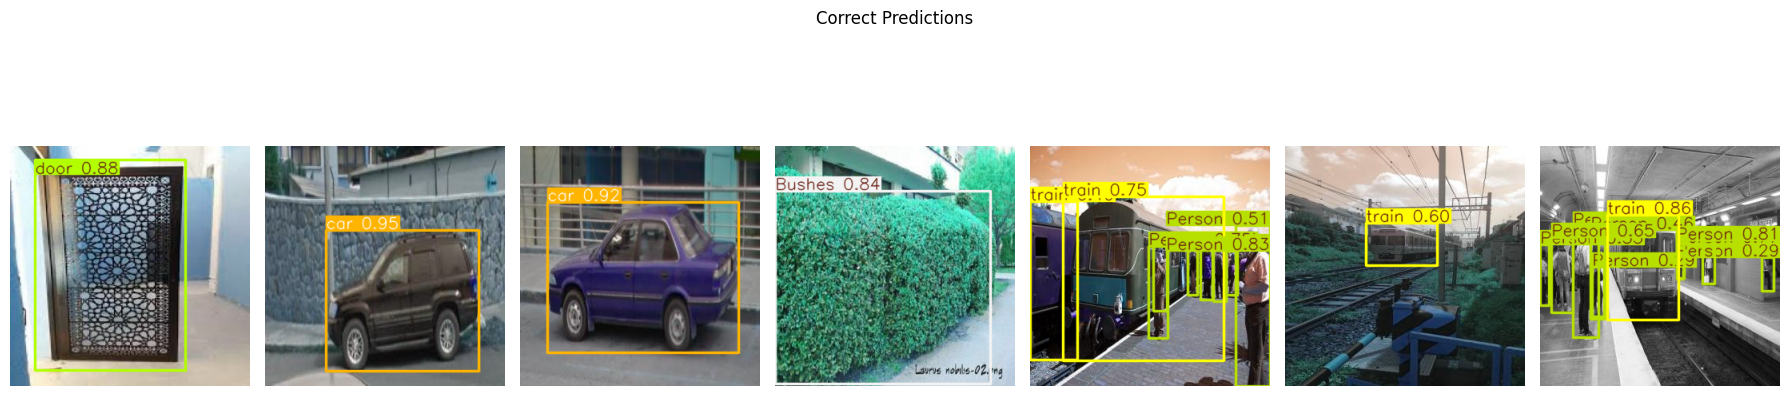

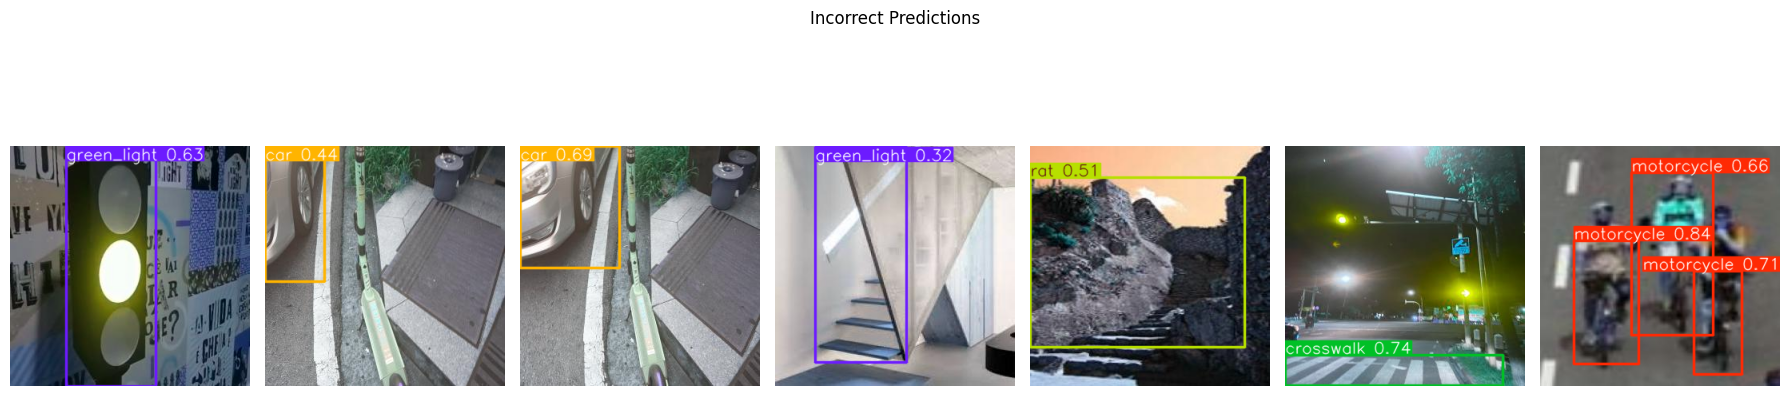

In [ ]:
""" nochmal ueberarbeiten """

def show(imgs, title):
    if not imgs:
        print(f"No {title.lower()} to show.")
        return
    plt.figure(figsize=(18, 5))
    for i, r in enumerate(imgs):
        plt.subplot(1, len(imgs), i + 1)
        plt.imshow(r.plot())
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show(correct, "Correct Predictions")
show(incorrect, "Incorrect Predictions")

## 8. Conclusion

## 9. Areas for Further Exploration